In [1]:
from collections import Counter
from matplotlib import pyplot
from numpy import where

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
import xgboost as xgb
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from numpy import loadtxt
from numpy import sort
from numpy import mean
from sklearn.metrics import cohen_kappa_score
#from autoimpute.imputations import MultipleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


from sklearn.impute import SimpleImputer 
from sklearn.metrics import plot_confusion_matrix
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

### Reading the data

In [2]:
df = pd.read_excel("Updated_UKBioBank.xlsx")

In [3]:
### removing the redundant column as advised by collaborators
df = df.iloc[:, df.columns != 'QTrest']

### Imputing values using SimpleImputer

In [4]:
imp = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
Imputed_df = imp.fit_transform(df)
# # 

In [5]:
df = pd.DataFrame(Imputed_df)
df = df.rename(columns={0: "eid", 1: "sex", 2:'RRrest', 3:'Tperest', 4:'QTc', 5:'QRS_rest', 6:'Age',
                       7:'BMI', 8:'Diab', 9:'smoke', 10:'DBP', 11:'SBP', 12:'chol', 13:'PR', 14:'AF', 15:'Arr'})

In [6]:
df.columns

Index(['eid', 'sex', 'RRrest', 'Tperest', 'QTc', 'QRS_rest', 'Age', 'BMI',
       'Diab', 'smoke', 'DBP', 'SBP', 'chol', 'PR', 'AF', 'Arr'],
      dtype='object')

In [7]:
df_no_overlap = df[~((df['AF']==1) & (df['Arr']==1))] # dataset where the patients that have both cases have been removed

In [8]:
healthy_patients = df_no_overlap[((df_no_overlap['AF']==0) & (df_no_overlap['Arr']==0))]

In [9]:
only_disease_df = df_no_overlap[((df_no_overlap['AF']==1) | (df_no_overlap['Arr']==1))] 

In [10]:
only_disease_df.shape

(1844, 16)

In [11]:
df_no_overlap.shape

(53895, 16)

In [12]:
### I am going to add the disease label now so I can remove outliers

In [13]:
only_disease_df.loc[(only_disease_df['Arr'] == 0) & (only_disease_df['AF'] == 1), 'Disease'] = 0
only_disease_df.loc[(only_disease_df['Arr'] == 1) & (only_disease_df['AF'] == 0), 'Disease'] = 1

C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(new_indexer, value)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [14]:
only_disease_df.head()

,eid,sex,RRrest,Tperest,QTc,QRS_rest,Age,BMI,Diab,smoke,DBP,SBP,chol,PR,AF,Arr,Disease
35,1003429.0,1.0,0.968,0.0645,0.355230,96.0,74.0,34.8141,0.0,0.0,85.5,141.5,0.0,166.0,1.0,0.0,0.0
44,1003947.0,1.0,0.858,0.0585,0.361661,76.0,67.0,28.8612,0.0,0.0,85.5,154.5,1.0,389.0,1.0,0.0,0.0
196,1017479.0,0.0,0.861,0.0690,0.452635,69.0,67.0,25.5567,0.0,0.0,64.5,116.0,0.0,131.0,1.0,0.0,0.0
199,1017854.0,1.0,0.807,0.0665,0.387941,50.0,43.0,32.2029,0.0,0.0,81.0,131.0,0.0,146.0,1.0,0.0,0.0
215,1019465.0,0.0,1.020,0.0525,0.382692,44.0,64.0,29.9301,0.0,0.0,84.0,152.5,1.0,138.0,1.0,0.0,0.0


### Isolation Forest

In [15]:
from sklearn.ensemble import IsolationForest
data = only_disease_df.drop(columns=['AF', 'Arr']).to_numpy()
X , y = data[:, :-1], data[:, -1]

iso = IsolationForest(contamination=0.3)
yhat = iso.fit_predict(X)
# select all rows that are not outliers
mask = yhat != -1
afterX, aftery = X[mask, :], y[mask]

In [16]:
print('No of AF cases before', y[y== 0].shape)
print('No of AF cases after outlier removal', aftery[aftery == 0].shape)

print('No of Arr cases before',y[y == 1].shape)
print('No of Arr cases after outlier removal', aftery[aftery== 1].shape)

No of AF cases before (1682,)
No of AF cases after outlier removal (1176,)
No of Arr cases before (162,)
No of Arr cases after outlier removal (115,)


In [17]:
unhealthy_df_no_outliers = pd.DataFrame(afterX,  columns = ['eid', 'sex', 'RRrest', 'Tperest', 'QTc', 'QRS_rest', 'Age', 'BMI', 'Diab', 'smoke', 'DBP', 'SBP', 'chol', 'PR'])

In [18]:
unhealthy_df_no_outliers.head()

,eid,sex,RRrest,Tperest,QTc,QRS_rest,Age,BMI,Diab,smoke,DBP,SBP,chol,PR
0,1022683.0,0.0,0.906,0.0715,0.419188,76.0,58.0,26.7149,0.0,1.0,98.0,151.5,0.0,162.0
1,1028491.0,0.0,0.854,0.0735,0.430679,69.0,62.0,28.7415,0.0,1.0,91.5,170.0,0.0,136.0
2,1028813.0,1.0,0.718,0.0570,0.395941,70.0,65.0,29.9921,0.0,0.0,92.5,144.5,0.0,145.0
3,1028911.0,1.0,0.858,0.0720,0.425356,63.0,65.0,31.6839,0.0,0.0,76.0,163.5,0.0,130.0
4,1030445.0,0.0,0.872,0.0800,0.410148,55.0,65.0,23.7500,0.0,0.0,72.0,126.5,0.0,157.0


In [19]:
test = unhealthy_df_no_outliers.copy()
kk = only_disease_df.copy()

j1 = test.set_index('eid').index
j2 = kk.set_index('eid').index
j3 = kk.set_index('eid').index
unhealthy_df_no_outliers =  kk[j3.isin(j1)]

In [20]:
unhealthy_df_no_outliers.head()

,eid,sex,RRrest,Tperest,QTc,QRS_rest,Age,BMI,Diab,smoke,DBP,SBP,chol,PR,AF,Arr,Disease
256,1022683.0,0.0,0.906,0.0715,0.419188,76.0,58.0,26.7149,0.0,1.0,98.0,151.5,0.0,162.0,1.0,0.0,0.0
310,1028491.0,0.0,0.854,0.0735,0.430679,69.0,62.0,28.7415,0.0,1.0,91.5,170.0,0.0,136.0,1.0,0.0,0.0
314,1028813.0,1.0,0.718,0.0570,0.395941,70.0,65.0,29.9921,0.0,0.0,92.5,144.5,0.0,145.0,1.0,0.0,0.0
317,1028911.0,1.0,0.858,0.0720,0.425356,63.0,65.0,31.6839,0.0,0.0,76.0,163.5,0.0,130.0,1.0,0.0,0.0
333,1030445.0,0.0,0.872,0.0800,0.410148,55.0,65.0,23.7500,0.0,0.0,72.0,126.5,0.0,157.0,1.0,0.0,0.0


In [21]:
### setting aside test sample so the classifier doesn't perform data leakage

In [22]:
choosing_samples_AF = unhealthy_df_no_outliers[unhealthy_df_no_outliers['AF'] == 1]
choosing_samples_Arr =  unhealthy_df_no_outliers[unhealthy_df_no_outliers['Arr'] == 1]

test_AF_samples = choosing_samples_AF.sample(10, replace=False, random_state = 123)
test_Arr_samples = choosing_samples_Arr.sample(10, replace=False, random_state = 123)

In [23]:
test_sample = pd.concat([test_AF_samples, test_Arr_samples])

In [24]:
#test_sample = without_outliers.sample(100, replace=False, random_state = 123)
j1 = test_sample.set_index('eid').index
j2 = unhealthy_df_no_outliers.set_index('eid').index
j3 = unhealthy_df_no_outliers.set_index('eid').index
sample_to_use = unhealthy_df_no_outliers[~j2.isin(j1)]
sample_to_use_withlabels =  unhealthy_df_no_outliers[~j3.isin(j1)]

In [25]:
sample_to_use.shape

(1271, 17)

In [26]:
test_sample['Disease'].value_counts()

1.0    10
0.0    10
Name: Disease, dtype: int64

In [27]:
test_sample.columns

Index(['eid', 'sex', 'RRrest', 'Tperest', 'QTc', 'QRS_rest', 'Age', 'BMI',
       'Diab', 'smoke', 'DBP', 'SBP', 'chol', 'PR', 'AF', 'Arr', 'Disease'],
      dtype='object')

In [28]:
test_sample.shape

(20, 17)

In [29]:
sample_to_use.shape

(1271, 17)

In [30]:
AF_data = sample_to_use.drop(columns=['Arr'], axis=1) # data with only the AF label
Arr_data = sample_to_use.drop(columns=['AF'], axis=1) # data with only the Arr label

In [31]:
test_sample.loc[(test_sample['Arr'] == 0) | (test_sample['AF'] == 1), 'Disease'] = 0
test_sample.loc[(test_sample['Arr'] == 1) & (test_sample['AF'] == 0), 'Disease'] = 1

In [32]:
test_sample = test_sample[((test_sample['AF']==1) | (test_sample['Arr']==1))]

In [33]:
test_sample.head()


,eid,sex,RRrest,Tperest,QTc,QRS_rest,Age,BMI,Diab,smoke,DBP,SBP,chol,PR,AF,Arr,Disease
33698,4122318.0,0.0,0.840,0.076,0.431526,54.0,67.0,22.3922,0.0,1.0,83.0,142.5,0.0,91.0,1.0,0.0,0.0
47274,5395735.0,1.0,0.848,0.051,0.427314,68.0,60.0,32.9120,0.0,1.0,92.5,137.5,0.0,115.0,1.0,0.0,0.0
4218,1393662.0,0.0,1.034,0.046,0.390910,65.0,65.0,28.3984,0.0,1.0,77.0,126.5,0.0,134.0,1.0,0.0,0.0
14553,2356718.0,1.0,0.924,0.061,0.391158,70.0,69.0,32.3023,0.0,0.0,67.5,128.0,1.0,133.0,1.0,0.0,0.0
48977,5554295.0,0.0,0.896,0.076,0.428388,65.0,63.0,32.1589,0.0,1.0,89.0,160.5,0.0,146.0,1.0,0.0,0.0


In [34]:
sample_to_use = sample_to_use.drop(columns=['AF', 'Arr'])
X = sample_to_use.loc[:, ~sample_to_use.columns.isin(['Disease', 'eid'])]
y = sample_to_use['Disease']

In [35]:
unhealthy_df_no_outliers.shape

(1291, 17)

In [36]:
test_sample = test_sample.drop(columns=['AF', 'Arr'])
X_test = test_sample.loc[:, ~test_sample.columns.isin(['Disease','eid'])]
y_test = test_sample['Disease']

In [37]:
X_test.head()

,sex,RRrest,Tperest,QTc,QRS_rest,Age,BMI,Diab,smoke,DBP,SBP,chol,PR
33698,0.0,0.840,0.076,0.431526,54.0,67.0,22.3922,0.0,1.0,83.0,142.5,0.0,91.0
47274,1.0,0.848,0.051,0.427314,68.0,60.0,32.9120,0.0,1.0,92.5,137.5,0.0,115.0
4218,0.0,1.034,0.046,0.390910,65.0,65.0,28.3984,0.0,1.0,77.0,126.5,0.0,134.0
14553,1.0,0.924,0.061,0.391158,70.0,69.0,32.3023,0.0,0.0,67.5,128.0,1.0,133.0
48977,0.0,0.896,0.076,0.428388,65.0,63.0,32.1589,0.0,1.0,89.0,160.5,0.0,146.0


In [282]:
from sklearn import svm
from sklearn.ensemble import VotingClassifier
from sklearn import model_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
estimators = []

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
model1 = xgb.XGBClassifier(objective='binary:logistic', subsample=0.75,  
                          n_estimators=100, colsample_bytree = 0.99, learning_rate = 1,
                max_depth = 10,  gamma=5, alpha = 1, seed=123, use_label_encoder=False, eval_metric='error')

estimators.append(('XGBoost', model1))
estimators.append(('bayes', GaussianNB()))
estimators.append(('GradientDescent' , SGDClassifier(loss="modified_huber", penalty="elasticnet", max_iter=500)))
ensemble = VotingClassifier(estimators, voting = 'soft')
scoring = ['recall', 'f1']

In [283]:
ensemble.fit(X, y)
y_pred = ensemble.predict(X_test)

In [284]:
y_test.value_counts()

1.0    10
0.0    10
Name: Disease, dtype: int64

In [285]:
Counter(y_pred)

Counter({0.0: 10, 1.0: 10})

In [286]:
from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_pred)
print('f1_score: %.3f' % f1_score)
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)
print('Precision: %.3f' % precision)

from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %.3f' % recall)

f1_score: 0.500
Precision: 0.500
Recall: 0.500


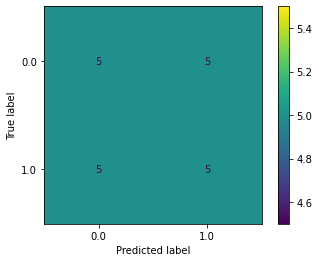

In [287]:
plot_confusion_matrix(ensemble, X_test, y_test) 

In [288]:
from sklearn.metrics import precision_recall_fscore_support,classification_report,confusion_matrix, precision_recall_curve
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.50      0.50      0.50        10
         1.0       0.50      0.50      0.50        10

    accuracy                           0.50        20
   macro avg       0.50      0.50      0.50        20
weighted avg       0.50      0.50      0.50        20

